# Employee Network Analysis
![](img/employee-network-analysis.jpg)

*A [DataCamp](https://datacamp.com) challenge* &nbsp;&nbsp;&nbsp;&nbsp;{octicon}`calendar` Mar, 2024  

{bdg-primary-line}`Network analysis`

## The project
You work in the analytics department of a multinational company, and the head of HR wants your help mapping out the company's employee network using message data. 

They plan to use the network map to understand interdepartmental dynamics better and explore how the company shares information. The ultimate goal of this project is to think of ways to improve collaboration throughout the company.

Create a report that covers the following:  
1. Which departments are the most/least active?
2. Which employee has the most connections? 
3. Identify the most influential departments and employees.
4. Using the network analysis, in which departments would you recommend the HR team focus to boost collaboration?

## The data

The company has six months of information on inter-employee communication. For privacy reasons, only sender, receiver, and message length information are available [(source)](https://snap.stanford.edu/data/CollegeMsg.html). 

`Messages` has information on the sender, receiver, and time.
- "sender" - represents the employee id of the employee sending the message.
- "receiver" - represents the employee id of the employee receiving the message.
- "timestamp" - the date of the message.
- "message_length" - the length in words of the message.

`Employees` has information on each employee.
- "id" - represents the employee id of the employee.
- "department" - is the department within the company. 
- "location" - is the country where the employee lives.
- "age" - is the age of the employee.

_**Acknowledgments:** Pietro Panzarasa, Tore Opsahl, and Kathleen M. Carley. "Patterns and dynamics of users' behavior and interaction: Network analysis of an online community." Journal of the American Society for Information Science and Technology 60.5 (2009): 911-932._

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

messages = pd.read_csv("data/messages.csv", parse_dates=["timestamp"])
messages

,sender,receiver,timestamp,message_length
0,79,48,2021-06-02 05:41:34,88
1,79,63,2021-06-02 05:42:15,72
2,79,58,2021-06-02 05:44:24,86
3,79,70,2021-06-02 05:49:07,26
4,79,109,2021-06-02 19:51:47,73
...,...,...,...,...
3507,469,1629,2021-11-24 05:04:57,75
3508,1487,1543,2021-11-26 00:39:43,25
3509,144,1713,2021-11-28 18:30:47,51
3510,1879,1520,2021-11-29 07:27:52,58


In [2]:
employees = pd.read_csv("data/employees.csv")
employees

,id,department,location,age
0,3,Operations,US,33
1,6,Sales,UK,50
2,8,IT,Brasil,54
3,9,Admin,UK,32
4,12,Operations,Brasil,51
...,...,...,...,...
659,1830,Admin,UK,42
660,1839,Admin,France,28
661,1879,Engineering,US,40
662,1881,Sales,Germany,57


## Company
The following graph shows the distribution, by location and by departments, of the 664 employees of the company.

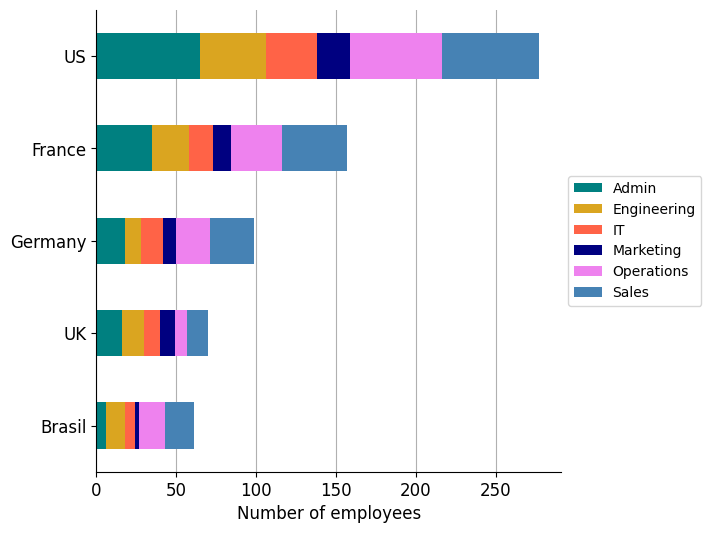

In [3]:
# Group employees by location and count them by department
employees_loc_dep = employees.pivot_table(
    index="location", columns="department", values="id", aggfunc="count"
)

# Calculate total employees by location
employees_loc_dep["total"] = employees_loc_dep.sum(axis=1)

# Sort values
employees_loc_dep = employees_loc_dep.sort_values(by="total", ascending=False)
# employees_loc_dep

# Define color palette
palette = ["teal", "goldenrod", "tomato", "navy", "violet", "steelblue"]

# Plot
fig, ax = plt.subplots(figsize=(6, 6))

employees_loc_dep.drop("total", axis=1).plot(
    ax=ax, kind="barh", stacked=True, color=palette
)
legend_h, legend_l = ax.get_legend_handles_labels()  # I will use it later
ax.grid(axis="x")
ax.set_axisbelow(True)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_title("", size=11)
ax.set_xlabel("Number of employees", fontsize=12)
ax.set_ylabel("")

ax.legend(bbox_to_anchor=(1.0, 0.5), loc="center left", fontsize=10)
ax.invert_yaxis()
sns.despine()

plt.show()

## Messages

### Between departments
These are the number of messages sent between departments. The size of the nodes represents the number of employees that each department has.

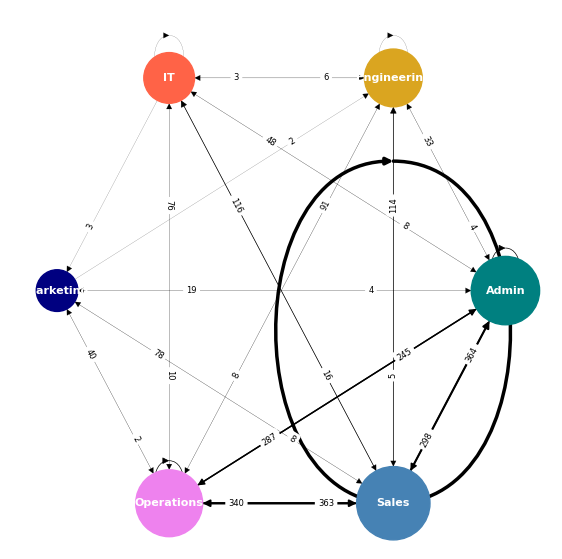

In [4]:
# Merge messages-employees dataframes on sender ids
senders = messages.merge(employees, how="left", left_on="sender", right_on="id").drop(
    "id", axis=1
)

# Rename columns
senders = senders.rename(
    columns={"department": "s_dep", "location": "s_loc", "age": "s_age"}
)

# Merge messages-employees dataframes on receiver ids
senders_receivers = senders.merge(
    employees, how="left", left_on="receiver", right_on="id"
).drop("id", axis=1)

# Rename columns
senders_receivers = senders_receivers.rename(
    columns={"department": "r_dep", "location": "r_loc", "age": "r_age"}
)

# senders_receivers.head()

# Pivot table on sender-receiver departments to count messages sent
dep_table = senders_receivers.pivot_table(
    index="s_dep", columns="r_dep", values="sender", aggfunc="count"
)

# Create a directional graph
D = nx.DiGraph()

# Add nodes: the set of departments
D.add_nodes_from(dep_table.index)

# Add edges
dep_edges = []
dep_msgs = []
for i in range(len(dep_table.index)):
    for j in range(len(dep_table.columns)):
        msgs = dep_table.iloc[i, j]
        if msgs > 0:
            dep_edges.append((dep_table.index[i], dep_table.columns[j]))
            dep_msgs.append(msgs)  # Store them to add metadata later

D.add_edges_from(dep_edges)

# Add metadata (number of messages) for each edge
for edge, message in zip(D.edges, dep_msgs):
    D.edges[edge]["messages"] = message.astype(int)

# D.edges(data=True) # Print edges with metadata

# Node colors
color_key = {department: color for department, color in zip(dep_table.index, palette)}
node_colors = [color_key[dept] for dept in D.nodes]

# Node size according to number of employees by department
department_employees = employees.groupby("department")["id"].count()
scale = 900  # Just to match desired size in the plot
dep_node_sizes = scale * department_employees / min(department_employees)

# Linewidth of the edges according to number of messages
dep_msgs_df = pd.DataFrame(dep_msgs, columns=["msgs"])
bins = [0, 100, 200, 300, 400, 500, 1000]
widths = [0.1, 0.5, 1.0, 1.5, 2.0, 2.5]
dep_msgs_df["linewidth"] = pd.cut(dep_msgs_df["msgs"], bins, labels=widths)
dep_msgs_df["dep_edges"] = dep_edges
linewidth_edges = dep_msgs_df.groupby("linewidth", observed=False)["dep_edges"].apply(
    list
)

# Layout of the graph
pos = nx.circular_layout(D)

# Plot
fig, ax = plt.subplots(figsize=(7, 7))

nx.draw_networkx_nodes(D, pos, ax=ax, node_size=dep_node_sizes, node_color=node_colors)
nx.draw_networkx_labels(
    D, pos, ax=ax, font_size=8, font_weight="bold", font_color="white"
)

for linewidth, edgelist in linewidth_edges.items():
    nx.draw_networkx_edges(
        D,
        pos,
        ax=ax,
        arrows=True,
        edgelist=edgelist,
        width=linewidth,
        node_size=list(dep_node_sizes),
    )

nx.draw_networkx_edge_labels(
    D,
    pos,
    ax=ax,
    edge_labels=nx.get_edge_attributes(D, "messages"),
    label_pos=0.3,
    font_size=6,
)

ax.axis("off")
plt.show()

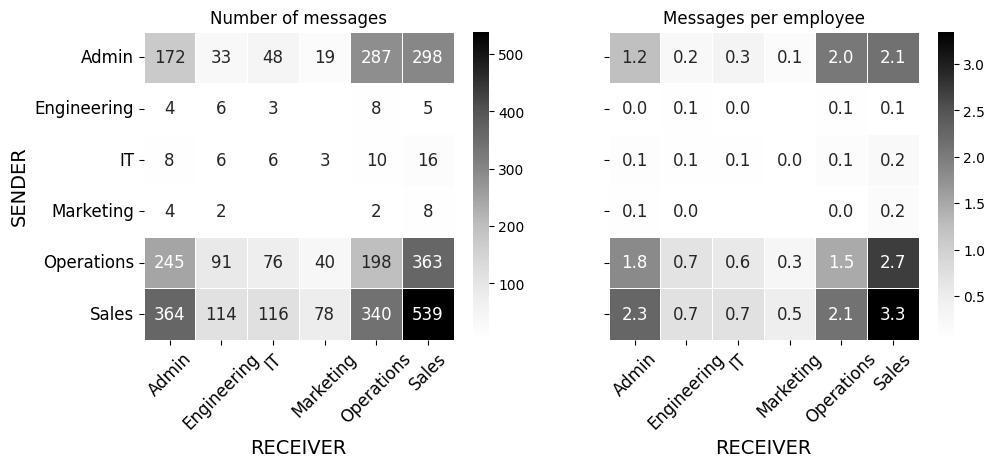

In [5]:
# Count number of employees per department
n_employees_dep = employees.pivot_table(
    index="department", values="id", aggfunc="count"
)

# Create table with messages per employee
dep_table_rel = dep_table.div(n_employees_dep.values, axis=0)  # Divide by row

# Plot
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(11, 4))

sns.heatmap(
    dep_table,
    ax=ax[0],
    cmap="Greys",
    annot=True,
    annot_kws={"size": 12},
    fmt=".0f",
    linewidths=0.4,
)

sns.heatmap(
    dep_table_rel,
    ax=ax[1],
    cmap="Greys",
    annot=True,
    annot_kws={"size": 12},
    fmt=".1f",
    linewidths=0.4,
)

for i in range(2):
    ax[i].tick_params(axis="x", labelsize=12, rotation=45)
    ax[i].tick_params(axis="y", labelsize=12)
    ax[i].set_xlabel("RECEIVER", fontsize=14)

ax[0].set_ylabel("SENDER", fontsize=14)
ax[1].set_ylabel("", fontsize=14)
ax[0].set_title("Number of messages", fontsize=12)
ax[1].set_title("Messages per employee", fontsize=12)

plt.show()

In the following graph, the size of the nodes represents the number of messages sent by each employee in that department, which is the number displayed in the node. The thickness of the connections is proportional to that quantity.

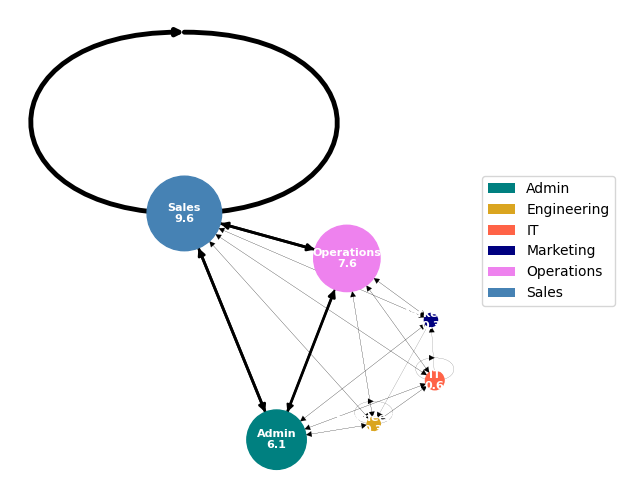

In [6]:
# Create a directional graph
D_rel = nx.DiGraph()

# Add nodes: the set of departments
D_rel.add_nodes_from(dep_table_rel.index)

# Add edges
dep_edges = []
dep_msgs = []
for i in range(len(dep_table_rel.index)):
    for j in range(len(dep_table_rel.columns)):
        msgs = dep_table_rel.iloc[i, j]
        if msgs > 0:
            dep_edges.append((dep_table_rel.index[i], dep_table_rel.columns[j]))
            dep_msgs.append(msgs)  # Store them to add metadata later

D_rel.add_edges_from(dep_edges)

# Add metadata (number of messages) for each edge
for edge, message in zip(D_rel.edges, dep_msgs):
    D_rel.edges[edge]["messages"] = message.astype(int)

# D.edges(data=True) # Print edges with metadata

# Node colors
color_key = {department: color for department, color in zip(dep_table.index, palette)}
node_colors = [color_key[dept] for dept in D_rel.nodes]

# Node size according to number of messages sent by department
sent_per_employee = round(dep_table_rel.sum(axis=1), 1)
scale = 300  # Just to match desired size in the plot
dep_node_sizes = scale * sent_per_employee

# Labels
labels = {
    n: str(n) + "\n" + str(sent) for n, sent in zip(D_rel.nodes(), sent_per_employee)
}

# Linewidth of the edges according to number of messages
dep_msgs_df = pd.DataFrame(dep_msgs, columns=["msgs"])
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
widths = [0.1, 1.5, 2.0, 3.5, 4.0, 5.5, 6.0, 7.5, 8.0, 9.5]
dep_msgs_df["linewidth"] = pd.cut(dep_msgs_df["msgs"], bins, labels=widths)
dep_msgs_df["dep_edges"] = dep_edges
linewidth_edges = dep_msgs_df.groupby("linewidth", observed=False)["dep_edges"].apply(
    list
)

# Layout of the graph
pos = nx.spiral_layout(D_rel)

# Plot
fig, ax = plt.subplots(figsize=(6, 6))

nx.draw_networkx_nodes(
    D_rel, pos, ax=ax, node_size=dep_node_sizes, node_color=node_colors
)
nx.draw_networkx_labels(
    D_rel,
    pos,
    ax=ax,
    font_size=8,
    font_weight="bold",
    font_color="white",
    labels=labels,
)

for linewidth, edgelist in linewidth_edges.items():
    nx.draw_networkx_edges(
        D_rel,
        pos,
        ax=ax,
        edgelist=edgelist,
        width=linewidth,
        node_size=list(dep_node_sizes),
    )

ax.legend(legend_h, legend_l, bbox_to_anchor=(1.0, 0.5), loc="center left", fontsize=10)

ax.axis("off")
plt.show()

The graph clearly shows that the majority of the traffic is generated by the triangle formed by the Sales, Admin, and Operations. Employees working in these departments send an average of more than six messages, while others do not reach even one message per employee.

The metric called _Degree Centrality_ is a measure of the number of neighbors a node has, divided by the total number it could possibly have.

In [7]:
# Degree centrality: Number of nbrs vs number of nbrs I could possibly have
degree_centrality_D = nx.degree_centrality(D)

# Sort
degree_centrality_D_sorted = sorted(
    degree_centrality_D.items(), key=lambda x: x[1], reverse=True
)

# List most important nodes-employees by degree centrality
degree_centrality_D_sorted  # = degree_centrality_D_sorted / max(degree_centrality_D_sorted)

# Print normalized values
_, max = degree_centrality_D_sorted[0]
print(f"Degree centrality:\n")
for dep, dc in degree_centrality_D_sorted:
    print(f"{dep} --> {dc/max:.1f}")

Degree centrality:

Admin --> 1.0
Operations --> 1.0
Sales --> 1.0
Engineering --> 0.9
IT --> 0.9
Marketing --> 0.7


These data indicate what we had already seen in the previous tables: while Admin Operations and Sales send to and receive from all departments, the rest lack some form of communication. Engineering is not sending to Marketing and IT is not receiving from Marketing. Marketing are not sending to IT and they do not send messages to themselves.

### Between locations
These are the number of messages sent between locations. The size of the nodes represents the number of employees that each location has.

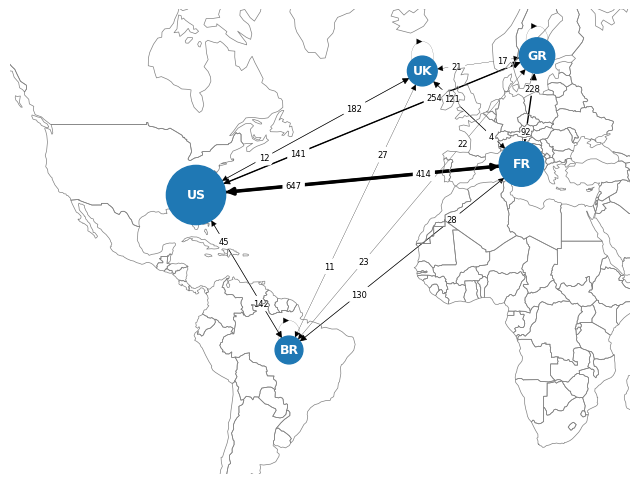

In [8]:
# Pivot table on sender-receiver locations to count messages sent
loc_table = senders_receivers.pivot_table(
    index="s_loc", columns="r_loc", values="sender", aggfunc="count"
)

# Create a directional graph
C = nx.DiGraph()

# Add nodes: the set of locations
C.add_nodes_from(loc_table.index)

# Add edges
loc_edges = []
loc_msgs = []
for i in range(len(loc_table.index)):
    for j in range(len(loc_table.columns)):
        msgs = loc_table.iloc[i, j]
        if msgs > 0:
            loc_edges.append((loc_table.index[i], loc_table.columns[j]))
            loc_msgs.append(msgs)  # Store them to add metadata later

C.add_edges_from(loc_edges)

# Add metadata (number of messages) for each edge
for edge, message in zip(C.edges, loc_msgs):
    C.edges[edge]["messages"] = message.astype(int)

# Node size according to number of employees by location
location_employees = employees.groupby("location")["id"].count()
scale = 400  # Just to match desired size in the plot
loc_node_sizes = scale * location_employees / min(location_employees)

# Linewidth of the edges according to number of messages
loc_msgs_df = pd.DataFrame(loc_msgs, columns=["msgs"])
bins = [0, 100, 200, 300, 400, 500, 1000]
widths = [0.1, 0.5, 1.0, 1.5, 2.0, 2.5]
loc_msgs_df["linewidth"] = pd.cut(loc_msgs_df["msgs"], bins, labels=widths)
loc_msgs_df["loc_edges"] = loc_edges
linewidth_edges = loc_msgs_df.groupby("linewidth", observed=False)["loc_edges"].apply(
    list
)

# Layout of the graph
# Adjust manually country positions for readibility
location_key = {
    "Brasil": (-6000000, -1000000),
    # "Brasil": (-4810350.913, -2620812.957),
    "France": (1500000, 5000000),
    # "France": (261933.923, 6250816.842),
    "Germany": (2000000, 8500000),
    # "Germany": (1491636.961, 6895388.529),
    "UK": (-1700000, 8000000),
    # "UK": (-13210.028, 6710566.113),
    "US": (-9000000, 4000000),
    # "US": (-8237165.598, 4971358.429),
}
pos = {n: location_key[n] for n in C.nodes()}

# Labels
label_key = {"Brasil": "BR", "France": "FR", "Germany": "GR", "UK": "UK", "US": "US"}
labels = {n: label_key[n] for n in C.nodes()}

# Prepare world map background from GeoPandas in projection 3857
# naturalearth_lowres = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # <- deprecated
naturalearth_lowres = gpd.read_file("map/ne_110m_admin_0_countries.shp")
naturalearth_lowres_3857 = naturalearth_lowres.copy()
naturalearth_lowres_3857.geometry = naturalearth_lowres_3857.geometry.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))

naturalearth_lowres_3857.boundary.plot(ax=ax, edgecolor="grey", linewidth=0.5)
ax.set_xlim(-1.5e7, 0.5e7)
ax.set_ylim(-0.5e7, 1e7)

nx.draw_networkx_nodes(C, pos, ax=ax, node_size=loc_node_sizes)
nx.draw_networkx_labels(
    C, pos, ax=ax, font_size=9, font_weight="bold", font_color="white", labels=labels
)

for linewidth, edgelist in linewidth_edges.items():
    nx.draw_networkx_edges(
        C,
        pos,
        ax=ax,
        arrows=True,
        edgelist=edgelist,
        width=linewidth,
        node_size=list(loc_node_sizes),
    )

nx.draw_networkx_edge_labels(
    C,
    pos,
    ax=ax,
    edge_labels=nx.get_edge_attributes(C, "messages"),
    label_pos=0.3,
    font_size=6,
    rotate=False,
)

ax.axis("off")
plt.show()

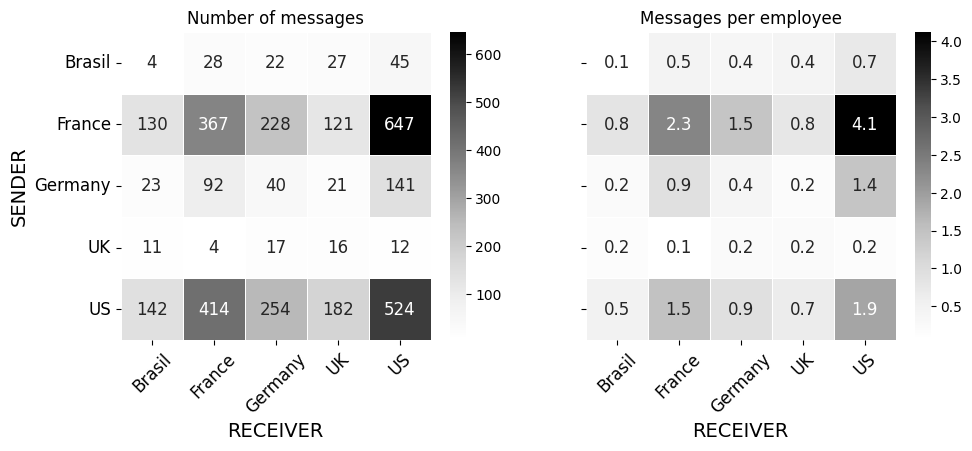

In [9]:
# Count number of employees per location
n_employees_loc = employees.pivot_table(index="location", values="id", aggfunc="count")

# Create table with messages per employee
loc_table_rel = loc_table.div(n_employees_loc.values, axis=0)  # Divide by row

# Plot
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(11, 4))

sns.heatmap(
    loc_table,
    ax=ax[0],
    cmap="Greys",
    annot=True,
    annot_kws={"size": 12},
    fmt=".0f",
    linewidths=0.4,
)

sns.heatmap(
    loc_table_rel,
    ax=ax[1],
    cmap="Greys",
    annot=True,
    annot_kws={"size": 12},
    fmt=".1f",
    linewidths=0.4,
)

for i in range(2):
    ax[i].tick_params(axis="x", labelsize=12, rotation=45)
    ax[i].tick_params(axis="y", labelsize=12, rotation=0)
    ax[i].set_xlabel("RECEIVER", fontsize=14)

ax[0].set_ylabel("SENDER", fontsize=14)
ax[1].set_ylabel("", fontsize=14)
ax[0].set_title("Number of messages", fontsize=12)
ax[1].set_title("Messages per employee", fontsize=12)

plt.show()

In the following graph, the size of the nodes represents the number of messages sent by employee in each location, which is the number displayed in the node. The thickness of the connections is proportional to that quantity.

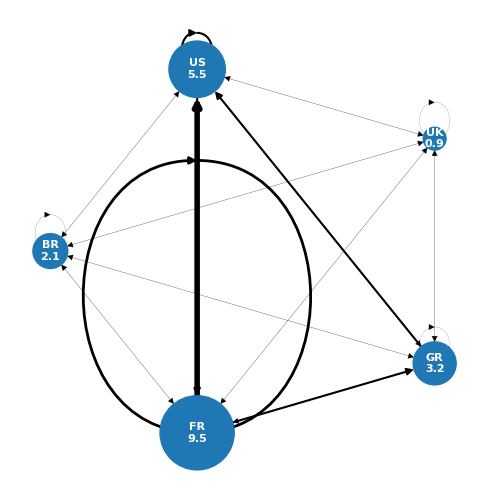

In [10]:
# Create a directional graph
C_rel = nx.DiGraph()

# Add nodes: the set of departments
C_rel.add_nodes_from(loc_table_rel.index)

# Add edges
dep_edges = []
dep_msgs = []
for i in range(len(loc_table_rel.index)):
    for j in range(len(loc_table_rel.columns)):
        msgs = loc_table_rel.iloc[i, j]
        if msgs > 0:
            dep_edges.append((loc_table_rel.index[i], loc_table_rel.columns[j]))
            dep_msgs.append(msgs)  # Store them to add metadata later

C_rel.add_edges_from(dep_edges)

# Add metadata (number of messages) for each edge
for edge, message in zip(C_rel.edges, dep_msgs):
    C_rel.edges[edge]["messages"] = message.astype(int)


# Node size according to number of messages sent by department
sent_per_employee = round(loc_table_rel.sum(axis=1), 1)
scale = 300  # Just to match desired size in the plot
dep_node_sizes = scale * sent_per_employee

# Labels
label_key = {"Brasil": "BR", "France": "FR", "Germany": "GR", "UK": "UK", "US": "US"}
labels = {
    n: label_key[n] + "\n" + str(sent)
    for n, sent in zip(C_rel.nodes(), sent_per_employee)
}

# Linewidth of the edges according to number of messages
dep_msgs_df = pd.DataFrame(dep_msgs, columns=["msgs"])
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
widths = [0.1, 1.5, 2.0, 3.5, 4.0, 5.5, 6.0, 7.5, 8.0, 9.5]
dep_msgs_df["linewidth"] = pd.cut(dep_msgs_df["msgs"], bins, labels=widths)
dep_msgs_df["dep_edges"] = dep_edges
linewidth_edges = dep_msgs_df.groupby("linewidth", observed=False)["dep_edges"].apply(
    list
)

# Layout of the graph
pos = nx.shell_layout(C_rel)

# Plot
fig, ax = plt.subplots(figsize=(6, 6))

nx.draw_networkx_nodes(C_rel, pos, ax=ax, node_size=dep_node_sizes)
nx.draw_networkx_labels(
    C_rel,
    pos,
    ax=ax,
    font_size=8,
    font_weight="bold",
    font_color="white",
    labels=labels,
)

for linewidth, edgelist in linewidth_edges.items():
    nx.draw_networkx_edges(
        C_rel,
        pos,
        ax=ax,
        edgelist=edgelist,
        width=linewidth,
        node_size=list(dep_node_sizes),
    )

ax.axis("off")
plt.show()

The predominance of France is clearly evident, with nearly 10 messages per employee, most of them directed towards the US, which comes second. Following are Germany, Brazil, and lastly the UK, which doesn't even reach one email sent per employee.

Nevertheless, all countries have communicated with each other according to the values of Degree Centrality.

In [11]:
# Degree centrality: Number of nbrs vs number of nbrs I could possibly have
degree_centrality_C = nx.degree_centrality(C)

# Sort
degree_centrality_C_sorted = sorted(
    degree_centrality_C.items(), key=lambda x: x[1], reverse=True
)

# List most important nodes-employees by degree centrality
degree_centrality_C_sorted

# Print normalized values
_, max = degree_centrality_D_sorted[0]
print(f"Degree centrality:\n")
for loc, dc in degree_centrality_C_sorted:
    print(f"{loc} --> {dc/max:.1f}")

Degree centrality:

Brasil --> 1.0
France --> 1.0
Germany --> 1.0
UK --> 1.0
US --> 1.0


### Departments in locations
Let's consider messages sent by each department in each location. The size of the nodes represents the number of employees that each department has at that particular location.

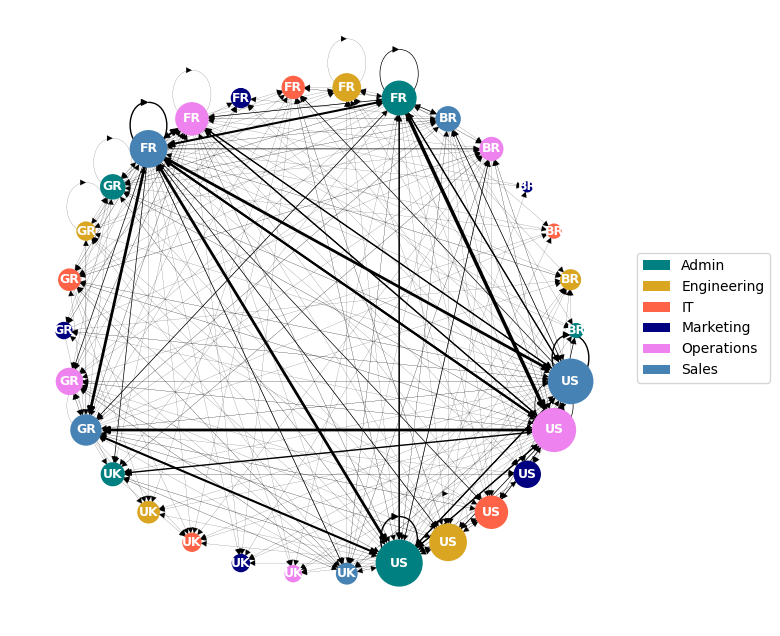

In [12]:
# Pivot table on sender-receiver departments and locations to count messages sent
msg_table = senders_receivers.pivot_table(
    index=["s_loc", "s_dep"],
    columns=["r_loc", "r_dep"],
    values="sender",
    aggfunc="count",
)

# Create a directional graph
DC = nx.DiGraph()

# Add nodes: the set of departments
DC.add_nodes_from(msg_table.columns)

# Add edges
deploc_edges = []
deploc_msgs = []
for i in range(len(msg_table.index)):
    for j in range(len(msg_table.columns)):
        msgs = msg_table.iloc[i, j]
        if msgs > 0:
            deploc_edges.append((msg_table.index[i], msg_table.columns[j]))
            deploc_msgs.append(msgs)

DC.add_edges_from(deploc_edges)

# Add metadata (number of messages) for each edge
for edge, message in zip(DC.edges, deploc_msgs):
    DC.edges[edge]["messages"] = message.astype(int)

# Plotting to a polygon background

node_color = []
for n in range(len(DC.nodes())):
    node_color.append(color_key[list(DC.nodes())[n][1]])

# Node size according to number of employees by department
location_department_employees = employees.groupby(["location", "department"])[
    "id"
].count()
scale = 50
node_sizes = scale * location_department_employees / min(location_department_employees)


# Linewidth of the edges according to number of messages
deploc_msgs_df = pd.DataFrame(deploc_msgs, columns=["msgs"])
bins = [0, 20, 40, 60, 80, 100, 1000]
widths = [0.1, 0.5, 1.0, 1.5, 2.0, 2.5]
deploc_msgs_df["linewidth"] = pd.cut(deploc_msgs_df["msgs"], bins, labels=widths)
deploc_msgs_df["deploc_edges"] = deploc_edges
linewidth_edges = deploc_msgs_df.groupby("linewidth", observed=False)[
    "deploc_edges"
].apply(list)


pos = nx.circular_layout(DC)

label_key = {"Brasil": "BR", "France": "FR", "Germany": "GR", "UK": "UK", "US": "US"}
labels = {
    n: label_key[list(DC.nodes())[i][0]]
    for n, i in zip(DC.nodes(), range(len(list(DC.nodes()))))
}


# Plot
fig, ax = plt.subplots(figsize=(8, 8))

nx.draw_networkx_nodes(DC, pos, ax=ax, node_size=node_sizes, node_color=node_color)
nx.draw_networkx_labels(
    DC, pos, ax=ax, font_size=9, font_weight="bold", font_color="white", labels=labels
)

for linewidth, edgelist in linewidth_edges.items():
    nx.draw_networkx_edges(
        DC,
        pos,
        ax=ax,
        arrows=True,
        edgelist=edgelist,
        width=linewidth,
        node_size=list(node_sizes),
    )

ax.legend(legend_h, legend_l, bbox_to_anchor=(1.0, 0.5), loc="center left", fontsize=10)

ax.axis("off")
plt.show()

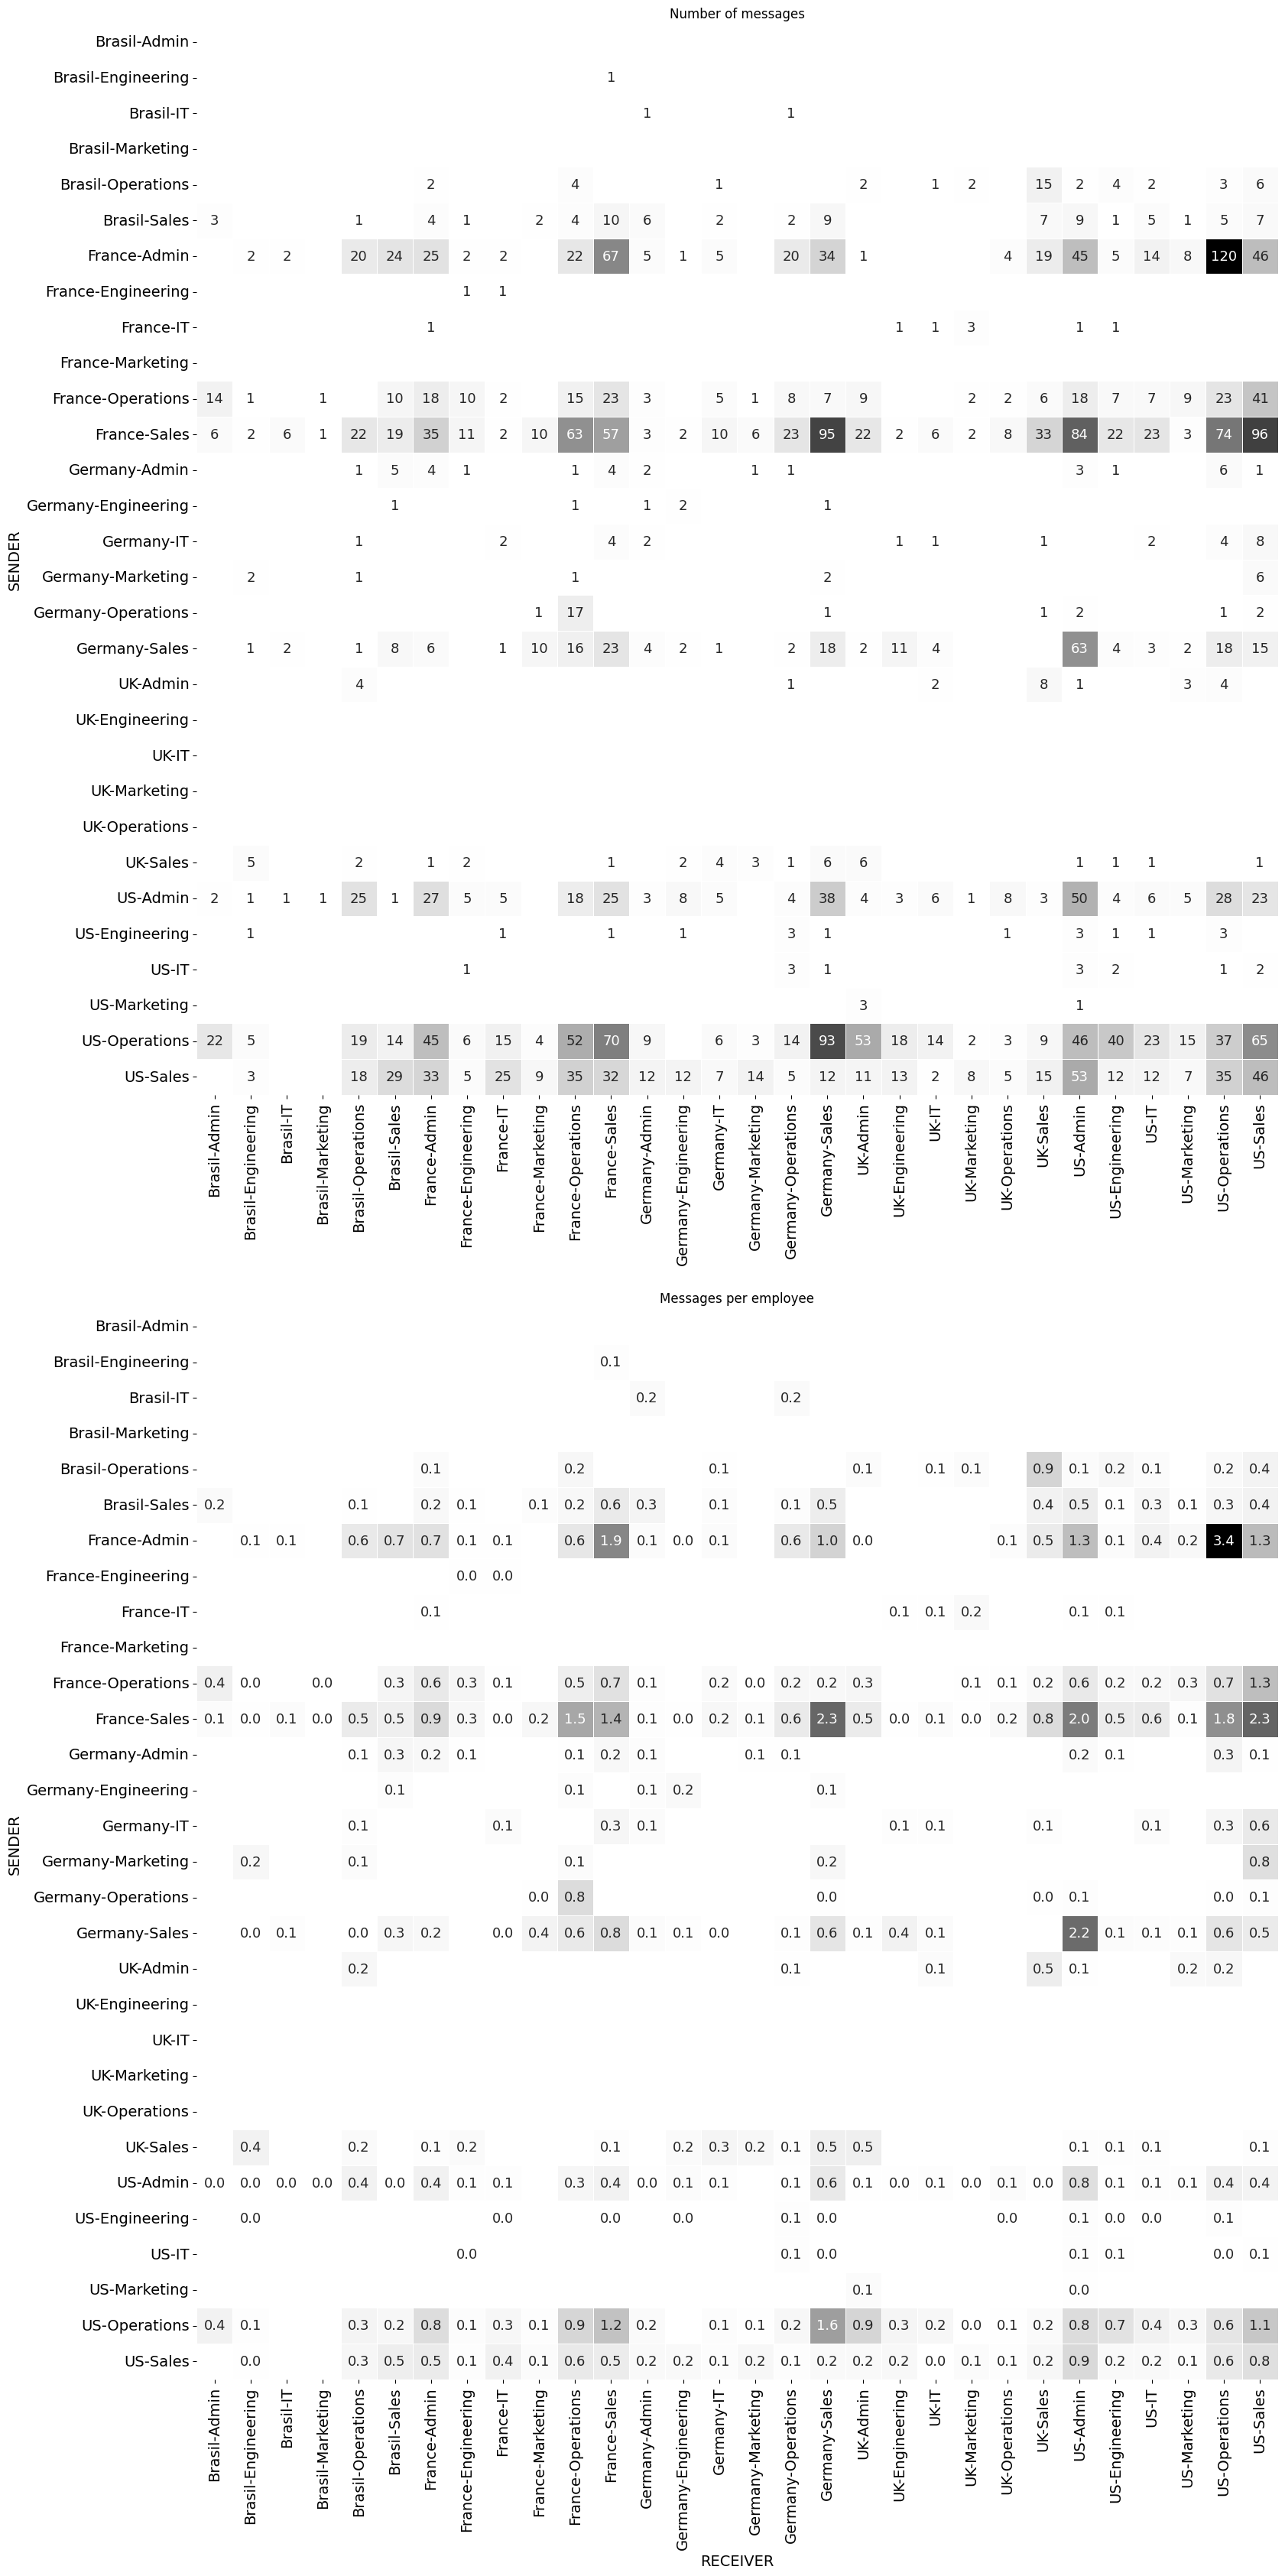

In [13]:
# Number of employees per location and department
n_employees_loc_dep = employees.pivot_table(
    index=["location", "department"], values="id", aggfunc="count"
)

# Reindex the table because some entities had no sent messages and do no appear
msg_table = msg_table.reindex(n_employees_loc_dep.index)

# Create table with messages per employee
msg_table_rel = msg_table.div(n_employees_loc_dep.values, axis=0)  # Divide by row

# Plot
fig, ax = plt.subplots(2, 1, figsize=(18.25, 40))

sns.heatmap(
    msg_table,
    ax=ax[0],
    cmap="Greys",
    annot=True,
    annot_kws={"size": 13},
    fmt=".0f",
    linewidths=0.4,
    cbar=False,
)

sns.heatmap(
    msg_table_rel,
    ax=ax[1],
    cmap="Greys",
    annot=True,
    annot_kws={"size": 13},
    fmt=".1f",
    linewidths=0.4,
    cbar=False,
)

for i in range(2):
    ax[i].tick_params(axis="x", labelsize=14)
    ax[i].tick_params(axis="y", labelsize=14)
    ax[i].set_ylabel("SENDER", fontsize=14)

ax[0].set_xlabel("", fontsize=14)
ax[1].set_xlabel("RECEIVER", fontsize=14)
ax[0].set_title("Number of messages", fontsize=12)
ax[1].set_title("Messages per employee", fontsize=12)


plt.show()

In the following graph, the size of the nodes represents the number of messages sent by employee in each department and location, which is the number displayed in the node. The thickness of the connections is proportional to that quantity.

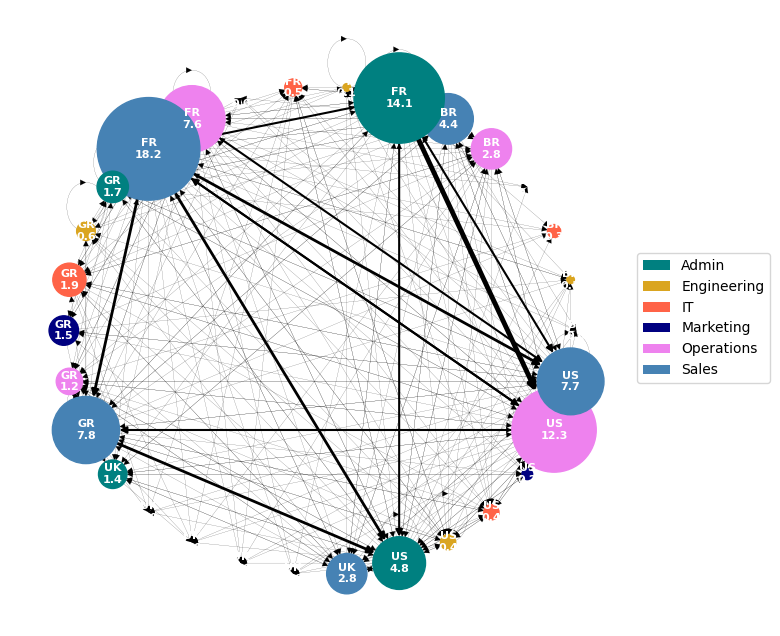

In [14]:
# Create a directional graph
DC_rel = nx.DiGraph()

# Add nodes: the set of departments
DC_rel.add_nodes_from(msg_table_rel.index)

# Add edges
dep_edges = []
dep_msgs = []
for i in range(len(msg_table_rel.index)):
    for j in range(len(msg_table_rel.columns)):
        msgs = msg_table_rel.iloc[i, j]
        if msgs > 0:
            dep_edges.append((msg_table_rel.index[i], msg_table_rel.columns[j]))
            dep_msgs.append(msgs)  # Store them to add metadata later

DC_rel.add_edges_from(dep_edges)

# Add metadata (number of messages) for each edge
for edge, message in zip(DC_rel.edges, dep_msgs):
    DC_rel.edges[edge]["messages"] = message.astype(int)

# Node colors
color_key = {department: color for department, color in zip(dep_table.index, palette)}
node_colors = []
for n in DC_rel.nodes:
    node_colors.append(color_key[n[1]])
    # node_colors.append(color_key[list(DC_rel.nodes())[n][1]])

# Node size according to number of messages sent by department
sent_per_employee = round(msg_table_rel.sum(axis=1), 1)
scale = 300  # Just to match desired size in the plot
dep_node_sizes = scale * sent_per_employee

# Labels
label_key = {"Brasil": "BR", "France": "FR", "Germany": "GR", "UK": "UK", "US": "US"}
labels = {
    n: label_key[n[0]] + "\n" + str(sent)
    for n, sent in zip(DC_rel.nodes(), sent_per_employee)
}


# Linewidth of the edges according to number of messages
dep_msgs_df = pd.DataFrame(dep_msgs, columns=["msgs"])
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
widths = [0.1, 1.5, 2.0, 3.5, 4.0, 5.5, 6.0, 7.5, 8.0, 9.5]
dep_msgs_df["linewidth"] = pd.cut(dep_msgs_df["msgs"], bins, labels=widths)
dep_msgs_df["dep_edges"] = dep_edges
linewidth_edges = dep_msgs_df.groupby("linewidth", observed=False)["dep_edges"].apply(
    list
)

# Layout of the graph
pos = nx.circular_layout(DC_rel)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))

nx.draw_networkx_nodes(
    DC_rel, pos, ax=ax, node_size=dep_node_sizes, node_color=node_colors
)
nx.draw_networkx_labels(
    DC_rel,
    pos,
    ax=ax,
    font_size=8,
    font_weight="bold",
    font_color="white",
    labels=labels,
)

for linewidth, edgelist in linewidth_edges.items():
    nx.draw_networkx_edges(
        DC_rel,
        pos,
        ax=ax,
        edgelist=edgelist,
        width=linewidth,
        node_size=list(dep_node_sizes),
    )

ax.legend(legend_h, legend_l, bbox_to_anchor=(1.0, 0.5), loc="center left", fontsize=10)

ax.axis("off")
plt.show()

Next, I will represent in a comparative graph the values of the following parameters:
- _Degree Centrality_: already mentioned, this is the number of neighbors a node has, divided by the total number it could possibly have.
- _Betweennness Centrality_: is defined as the number of shortest paths in a graph that pass through a node divided by the number of shortest paths that exist between every pair of nodes in a graph. It captures bottleneck nodes in a graph, rather than highly connected nodes.

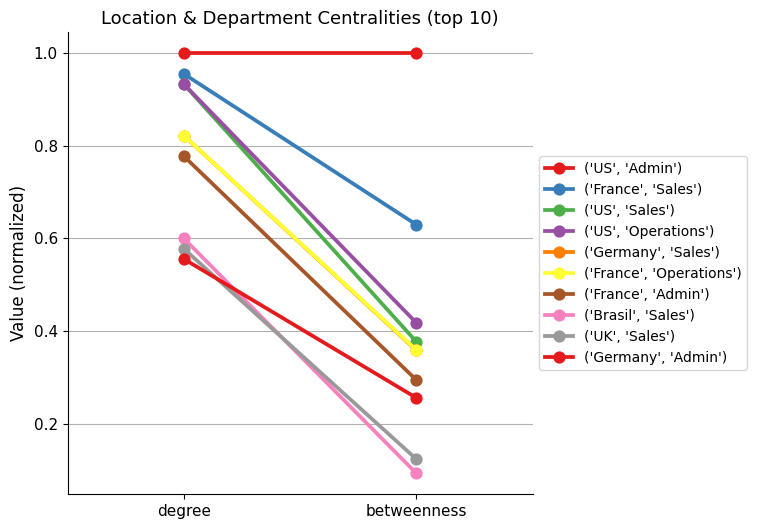

In [15]:
# Degree centrality
degree_centrality_DC = nx.degree_centrality(DC)
dc_DC = pd.DataFrame(
    degree_centrality_DC.items(), columns=["node", "degree"]
).set_index("node")
dc_DC = dc_DC.div(dc_DC.max())  # Normalize values

# Betweennness centrality
betweenness_centrality_DC = nx.betweenness_centrality(DC)
bc_DC = pd.DataFrame(
    betweenness_centrality_DC.items(), columns=["node", "betweenness"]
).set_index("node")
bc_DC = bc_DC.div(bc_DC.max())  # Normalize values

# Join dataframe in the index
centralities = dc_DC.join(bc_DC)

# Sort values and get top
centralities = centralities.sort_values(by="degree", ascending=False)
top = 10
centralities_top = centralities[:top]

# Melt dataframe to plot in seaborn
centralities_melted = centralities_top.reset_index().melt(id_vars=["node"])

# Plot
fig, ax = plt.subplots(figsize=(6, 6))

sns.pointplot(
    x="variable", y="value", data=centralities_melted, ax=ax, hue="node", palette="Set1"
)

ax.grid(axis="y")
ax.set_axisbelow(True)
ax.tick_params(axis="y", which="major", labelsize=11)
ax.tick_params(axis="x", which="major", labelsize=11)
ax.set_title("Location & Department Centralities (top 10)", size=13)
ax.set_xlabel("", size=12)
ax.set_ylabel("Value (normalized)", size=12)
ax.legend(bbox_to_anchor=(1.0, 0.5), loc="center left", fontsize=10)
sns.despine()

plt.show()

From this chart we learn that US Admin, despite not being the department that sends the most messages per employee, does have a prevalent position because it has the most connections in the network and serves as the main connecting point for the traffic in the network. So US Admin is the most influential node and the most critical one.

## Employee network
First of all, I'm going to take a look at the number of employees who sent messages or did not send them at all, combined with those who received them or did not receive them at all.

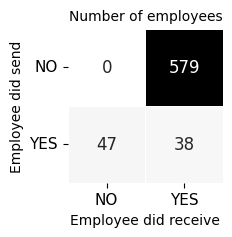

In [16]:
# Create sets
employees_set = set(employees["id"])
senders_set = set(messages["sender"])
receivers_set = set(messages["receiver"])
not_senders_set = [
    employee for employee in employees_set if employee not in senders_set
]
not_receivers_set = [
    employee for employee in employees_set if employee not in receivers_set
]

# Lists
sender_receiver = [
    employee
    for employee in employees_set
    if (employee in senders_set) and (employee in receivers_set)
]
sender_notreceiver = [
    employee
    for employee in employees_set
    if (employee in senders_set) and (employee not in receivers_set)
]
notsender_receiver = [
    employee
    for employee in employees_set
    if (employee not in senders_set) and (employee in receivers_set)
]
notsender_notreceiver = [
    employee
    for employee in employees_set
    if (employee not in senders_set) and (employee not in receivers_set)
]

# Dataframe
send_receive_df = pd.DataFrame(
    {
        "sent": ["NO", "YES"],
        "NO": [len(notsender_notreceiver), len(sender_notreceiver)],
        "YES": [len(notsender_receiver), len(sender_receiver)],
    }
)
send_receive_df = send_receive_df.set_index("sent")

# Plot
fig, ax = plt.subplots(figsize=(2, 2))

sns.heatmap(
    send_receive_df,
    ax=ax,
    cmap="Greys",
    annot=True,
    annot_kws={"size": 12},
    fmt=".0f",
    linewidths=0.4,
    cbar=False,
)


ax.tick_params(axis="x", labelsize=11, rotation=0)
ax.tick_params(axis="y", labelsize=11, rotation=0)
ax.set_xlabel("Employee did receive", fontsize=10)
ax.set_ylabel("Employee did send", fontsize=10)
ax.set_title("Number of employees", fontsize=10)

plt.show()

From the total number of 664 employees in the company, we learn that:

- 579 employees (87%) did not send any message despite receiving them.
- Among those who did send messages (100% - 87% = 13% <--> 47 + 38 = 85 from 664), 47 of them did not receive any response.

Next I will take a look to the top 10 sender employees:

In [17]:
print(
    senders_receivers.groupby("sender")["receiver"]
    .count()
    .sort_values(ascending=False)[:10]
    .to_frame()
    .rename(columns={"receiver": "msgs sent"})
)

        msgs sent
sender           
605           459
128           266
144           221
509           216
389           196
598           187
317           184
586           180
483           169
725           137


And here are the top centralities in the employee network:

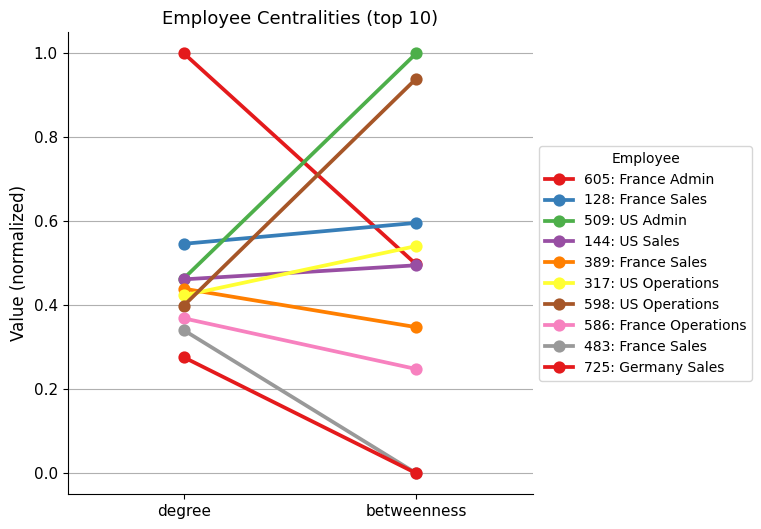

In [18]:
# Create a multi directed graph
E = nx.MultiDiGraph()

# Add nodes
E.add_nodes_from(list(employees["id"]))

# Add metadata for each node
for node, (_, employee) in zip(E.nodes, employees.iterrows()):
    E.nodes[node]["department"] = employee["department"]
    E.nodes[node]["location"] = employee["location"]
    E.nodes[node]["age"] = employee["age"]

# E.nodes(data=True)

# Add messages as edges of the gragh
E.add_edges_from(
    [(message["sender"], message["receiver"]) for _, message in messages.iterrows()]
)

# Add metadata for each edge
for edge, (_, message) in zip(E.edges, messages.iterrows()):
    E.edges[edge]["timestamp"] = message["timestamp"]
    E.edges[edge]["message_length"] = message["message_length"]

# Degree centrality
degree_centrality_E = nx.degree_centrality(E)
dc_E = pd.DataFrame(degree_centrality_E.items(), columns=["node", "degree"]).set_index(
    "node"
)
dc_E = dc_E.div(dc_E.max())  # Normalize values

# Betweennness centrality
betweenness_centrality_E = nx.betweenness_centrality(E)
bc_E = pd.DataFrame(
    betweenness_centrality_E.items(), columns=["node", "betweenness"]
).set_index("node")
bc_E = bc_E.div(bc_E.max())  # Normalize values

# Join dataframe in the index
centralities = dc_E.join(bc_E)

# Sort values and get top
centralities = centralities.sort_values(by="degree", ascending=False)
top = 10
centralities_top = centralities[:top]

# Melt dataframe to plot in seaborn
centralities_melted = centralities_top.reset_index().melt(id_vars=["node"])

# Plot
fig, ax = plt.subplots(figsize=(6, 6))

sns.pointplot(
    x="variable",
    y="value",
    data=centralities_melted,
    ax=ax,
    hue="node",
    hue_order=centralities_melted["node"][:top],
    palette="Set1",
)

ax.grid(axis="y")
ax.set_axisbelow(True)
ax.tick_params(axis="y", which="major", labelsize=11)
ax.tick_params(axis="x", which="major", labelsize=11)
ax.set_title("Employee Centralities (top 10)", size=13)
ax.set_xlabel("", size=12)
ax.set_ylabel("Value (normalized)", size=12)
# Legend
h, l = ax.get_legend_handles_labels()


def identify_employee(id):
    dep = employees.loc[employees["id"] == int(id), :].iat[0, 1]
    loc = employees.loc[employees["id"] == int(id), :].iat[0, 2]
    return loc + " " + dep


ax.legend(
    h,
    [label + ": " + identify_employee(label) for label in l],
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    fontsize=10,
    title="Employee",
)

sns.despine()

plt.show()

The data indicates that the employees who send the most messages are also the ones with the most neighbors, meaning they occupy the top positions in terms of Degree Centrality. However, their position in the top ten varies when considering Betweenness Centrality, that is, their importance in the flow of information.

The employee 605 (from France Admin) stands out clearly for their activity. However, other employees are better connected, such as the 509 (US Admin).

Below is the network diagram of the neighbors of employee 605 and employee 509, the top performers in terms of Degree Centrality and Betweenness Centrality, respectively.

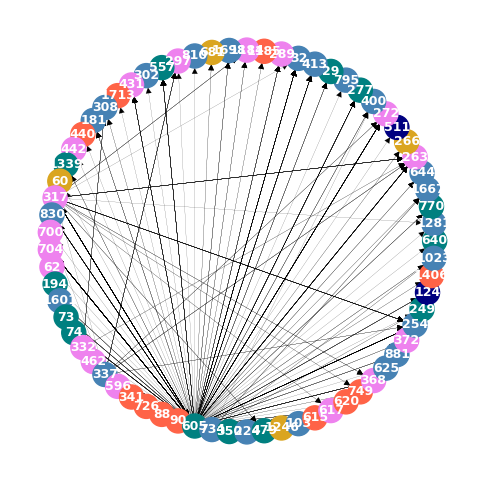

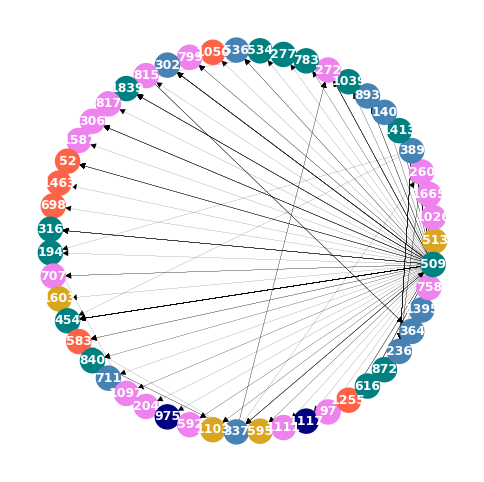

In [19]:
# Define subgraph plotting function
def plot_subgraph(subgrah):
    # Node colors
    departments = nx.get_node_attributes(subgrah, "department").values()
    node_colors = [color_key[dept] for dept in departments]
    # Node sizes
    node_sizes = 300
    # Layout
    pos = nx.circular_layout(subgrah)
    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))

    nx.draw_networkx_nodes(
        subgrah, pos, ax=ax, node_size=node_sizes, node_color=node_colors
    )
    nx.draw_networkx_labels(
        subgrah, pos, ax=ax, font_size=9, font_weight="bold", font_color="white"
    )
    nx.draw_networkx_edges(
        subgrah, pos, ax=ax, node_size=node_sizes, arrows=True, width=0.1
    )

    ax.axis("off")
    plt.show()


# Plot employee 605 neighbors
neighbors_605 = list(E.neighbors(605))
neighbors_605.append(605)
E_605 = E.subgraph(neighbors_605)
plot_subgraph(E.subgraph(E_605))

# Plot employee 509 neighbors
neighbors_509 = list(E.neighbors(509))
neighbors_509.append(509)
E_509 = E.subgraph(neighbors_509)
plot_subgraph(E.subgraph(E_509))

## Conclusions
Considering it in relative terms, that is, per employee, the Admin, Sales, and Operations departments of the US and France are the ones generating the bulk of the messages and are the most important in the flow of information within the organization. Comparatively, the rest of the departments seem less participative.

IT, Engineering, and especially Marketing barely communicate, and as for the countries, the UK stands out for its low activity.

It is striking the proportion of employees who did not send any messages (87%). And also, the fact that almost half of those who did send them, did not receive any response.

Regarding the most communicative employees, it is important to differentiate between the quantity of established connections and their importance in general terms of connectivity. In that sense, it was discovered that the employee who sent the most messages was surpassed by other employees who were initially less communicative when studying the relevance of those established contacts.